## YoloV8 ASL Recognition + Model Explainability

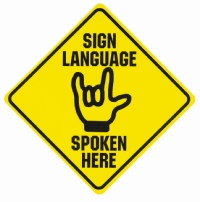

### 0. Imports, prep

In [2]:
!pip install imutils keras_cv_attention_models

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.8/748.8 kB 13.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.3 MB/s eta 0:00:00
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25838 sha256=b414756319c894d9ccff261f40d2f9cedb08c7cd25cb19014386d355122a4bd2
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [3]:
# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()
from dataclasses import dataclass

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras_cv_attention_models import yolov8
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
@dataclass
class CFG():
    batch_size: int = 64
    img_height: int = 64
    img_width: int = 64
    epochs: int = 25
    num_classes: int = 29
    img_channels: int = 3
    seed: int = 69

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)
tf.random.set_seed(CFG.seed)

### 1. Dataset exploration, preprocessing

In [5]:
# Labels
TRAIN_PATH = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
TEST_PATH = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"
labels = []
letters = list(string.ascii_uppercase)
labels.extend(letters)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [6]:
def plot_sample_imgs(labels, num_imgs=7):
    fig, axs = plt.subplots(len(labels), num_imgs + 1, figsize=(13, 12))
    
    for i, label in enumerate(labels):
        axs[i, 0].axis('off')
        axs[i, 0].text(0.5, 0.5, labels[i], va='center', ha='center')
        path_label = os.path.join(TRAIN_PATH, label)
        files = os.listdir(path_label)
        
        for j_imgs in range(1, num_imgs + 1):
            axs[i, j_imgs].axis('off')
            single_image_path = os.path.join(path_label, files[j_imgs])
            single_image = cv2.imread(single_image_path)
            single_image = cv2.cvtColor(single_image, cv2.COLOR_BGR2RGB)
            axs[i, j_imgs].imshow(single_image)
            

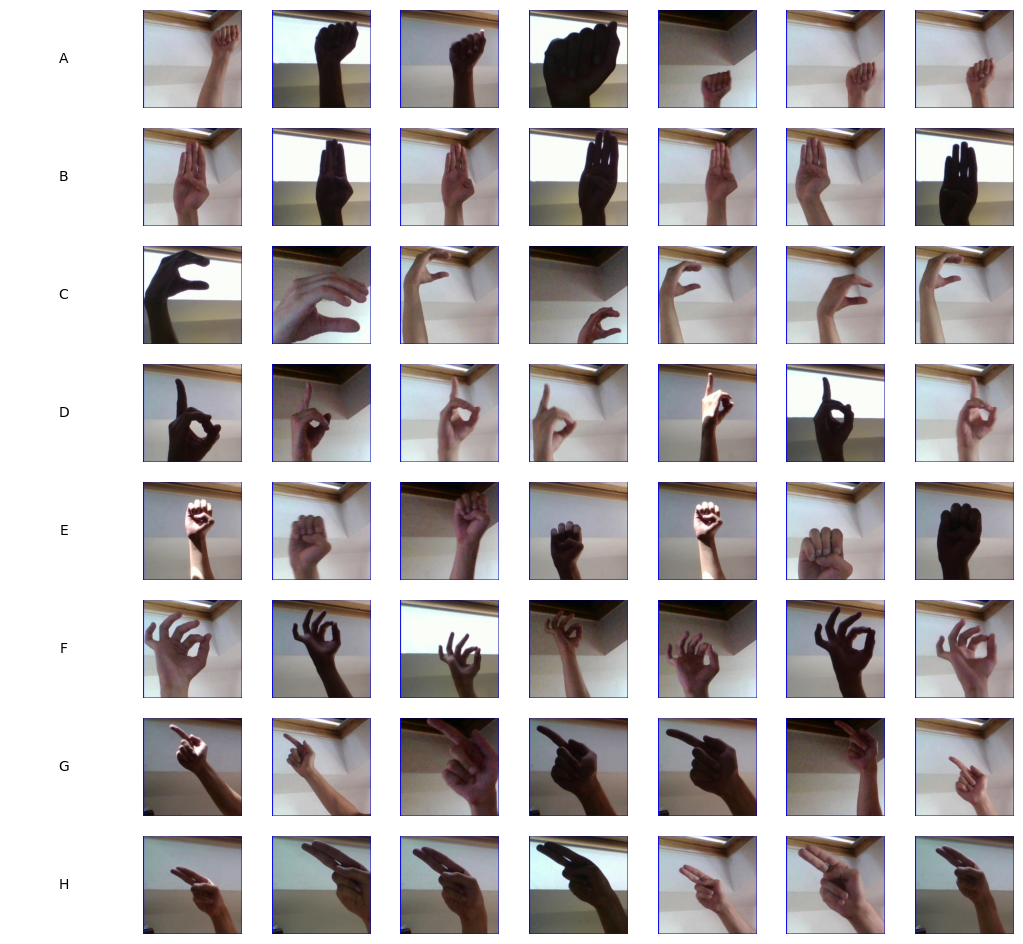

In [7]:
plot_sample_imgs(labels[:8])

Creating pd dataframe with file paths and target values:

In [8]:
image_paths = []
image_labels = []

for label in labels:
    image_path = os.path.join(TRAIN_PATH, label, '*')
    images_path = glob.glob(image_path)
    labels = [label] * len(images_path)
    image_paths += images_path
    image_labels += labels

data = pd.DataFrame({
    'path': image_paths,
    'label': image_labels
})   

data

,path,label
0,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
1,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
2,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
3,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
4,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
...,...,...
86995,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86996,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86997,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86998,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space


Train-val-test split (0.8 / 0.1 / 0.1)

In [9]:
test_size = val_size = 0.1
train_size = 0.8

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    data.path, data.label,
    test_size=test_size,
    random_state=CFG.seed,
    stratify=data.label,
    shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size / (train_size + test_size),
    random_state=CFG.seed,
    stratify=y_train,
    shuffle=True
)
X_train.shape, X_val.shape, X_test.shape

((69600,), (8700,), (8700,))

In [11]:
data_train = pd.DataFrame({
    'path': X_train,
    'label': y_train
})
data_val = pd.DataFrame({
    'path': X_val,
    'label': y_val
})
data_test = pd.DataFrame({
    'path': X_test,
    'label': y_test
})

Rescaling images

In [12]:
def rescale():
    datagen = ImageDataGenerator(rescale=1/255)
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory='./',
        x_col='path',
        y_col='label',
        class_mode='categorical',
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size
    )
    val_generator = datagen.flow_from_dataframe(
        data_val,
        directory='./',
        x_col='path',
        y_col='label',
        class_mode='categorical',
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size
    )
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory='./',
        x_col='path',
        y_col='label',
        class_mode='categorical',
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size
    )
    
    return train_generator, val_generator, test_generator
    

In [13]:
train_generator, validation_generator, test_generator = rescale()

Found 69600 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


### 2. Building and training YoloV8 with custom classification layers

In [14]:
base = yolov8.YOLOV8_N_CLS(pretrained="imagenet", input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

11185072/11185072 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/yolov8_n_cls_imagenet.h5


In [15]:
base.layers[-2]

In [16]:
for layer in base.layers:
    layer.trainable = False

In [17]:
x = base.layers[-2].output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='leaky_relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='leaky_relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
preds = Dense(29, activation='softmax')(x)

model = Model(inputs=base.input, outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 stem_1_pad (ZeroPadding2D)     (None, 66, 66, 3)    0           ['input_1[0][0]']                
                                                                                                  
 stem_1_conv (Conv2D)           (None, 32, 32, 16)   432         ['stem_1_pad[0][0]']             
                                                                                                  
 stem_1_bn (BatchNormalization)  (None, 32, 32, 16)  64          ['stem_1_conv[0][0]']            
                                                                                              

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('asl_yolov8_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
history = model.fit(
    train_generator,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/25
1088/1088 [==============================] - 446s 401ms/step - loss: 1.2148 - accuracy: 0.6247 - val_loss: 0.4081 - val_accuracy: 0.8893
Epoch 2/25
1088/1088 [==============================] - 129s 119ms/step - loss: 0.7670 - accuracy: 0.7500 - val_loss: 0.3236 - val_accuracy: 0.9141
Epoch 3/25
1088/1088 [==============================] - 97s 89ms/step - loss: 0.6611 - accuracy: 0.7828 - val_loss: 0.2585 - val_accuracy: 0.9346
Epoch 4/25
1088/1088 [==============================] - 101s 92ms/step - loss: 0.6015 - accuracy: 0.8002 - val_loss: 0.2277 - val_accuracy: 0.9444
Epoch 5/25
1088/1088 [==============================] - 99s 91ms/step - loss: 0.5563 - accuracy: 0.8142 - val_loss: 0.2037 - val_accuracy: 0.9467
Epoch 6/25
1088/1088 [==============================] - 104s 96ms/step - loss: 0.5237 - accuracy: 0.8266 - val_loss: 0.1890 - val_accuracy: 0.9513
Epoch 7/25
1088/1088 [==============================] - 105s 96ms/step - loss: 0.4978 - accuracy: 0.8337 - val_loss: 0

### 3. Model evaluation, metrics, visualising

In [ ]:
accuracy = model.evaluate(test_generator)

In [ ]:
# Visualize Training and Validation Results

# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy"], 
)

# Configuration Plot
class PlotCFG:
    marker_size = 8
    line_size = 2
    train_color = "#76503d"
    valid_color = "#deb392"

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5,
    width=950, height=400,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [ ]:
preds = model.predict(test_generator)
preds

In [ ]:
predictions = preds.argmax(axis=1)
predictions[:10]

In [ ]:
def show_predictions(test_path):
    image_path = os.path.join(TEST_PATH, '*')
    imgs = sorted(glob.glob(image_path))

    columns = 7
    row = round(len(imgs) / columns)
    labs = (train_generator.class_indices)
    labs = dict((v,k) for k,v in labs.items())

    fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    i, j = 0, 0

    for img_path in imgs:
        origin_img = cv2.imread(str(img_path))
        origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
        label = img_path.split('/')[-1].split('_')[0]
        
        img = cv2.resize(origin_img, (CFG.img_height, CFG.img_width))
#         img = preprocess_input(img)

        prediction = model.predict(img[None]/255, verbose=0)
        
        ax[i][j].imshow(origin_img)
        ax[i][j].set_title(f'GT {label}. Pred {labs[np.argmax(prediction, axis=1)[0]]}')
        ax[i][j].axis('off')
        j += 1
        if j == columns:
            j = 0
            i += 1

    plt.show();

In [ ]:
show_predictions(test_path=TEST_PATH)

### 4. Visualisation (TSNE)

I wanna look at latest (not including the output layer!) custom dense layer and try to make some predictions directly from it.

In [ ]:
model.layers

In [ ]:
dense_model = Model(inputs=model.inputs, outputs=model.layers[-4].output)
dense_model.summary()

In [ ]:
# Extract Features in Dense Layer
def dense_feature_prediction(img_path):
    img = load_img(img_path, target_size=(CFG.img_height, CFG.img_width))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]
    return dense_feature

reduction_data = pd.DataFrame()
for label in labels:
    label_data = data_test[data_test['label']==label][:100]
    reduction_data = reduction_data.append(label_data)

reduction_data = reduction_data.reset_index(drop=True)

dense_features = reduction_data['path'].progress_apply(dense_feature_prediction)
dense_features = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)
dense_features

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data

In [ ]:
# Scatter Plot
list_colors = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF4500", "#800080", "#32CD32", "#8B0000", 
               "#000080", "#808000", "#FF6347", "#008080", "#FF1493", "#7FFF00", "#D2691E", "#9400D3", "#B22222", "#ADFF2F",
               "#ADD8E6", "#FF69B4", "#F0E68C", "#4682B4", "#9ACD32", "#800000", "#FFD700", "#20B2AA", "#A52A2A"
              ]
fig = px.scatter(
    reduction_data, x="tsne_feat_0", y="tsne_feat_1", color='label', color_discrete_sequence=list_colors
)

fig.update_traces(marker=dict(size=8),)

# Update Axes
fig.update_xaxes(title="", linecolor="Black", zeroline=False, mirror=True)
fig.update_yaxes(title="", linecolor="Black", zeroline=False, mirror=True)

# Update Layout
fig.update_layout(
    title_text="t-SNE Visualization", title_x=0.5,
    width=900, height=900,
    plot_bgcolor='White',
    coloraxis_showscale=False,
)

# Show
fig.show()

### 5. Class Activation Maps (Grad-CAM)

reference: https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
            
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])
        
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        
        # return the resulting heatmap to the calling function
        return heatmap
    
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
def gradcam_images(labels):
    # Create Subplots
    fig, axs = plt.subplots(len(labels), 7, figsize=(12, 10))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')
        
        label_data = data_test[data_test['label']==label][:2].reset_index(drop=True)

        for j in range(2):
            # Read Original Image
            orig = cv2.imread(label_data['path'][j])
            orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
            
            # Preprocess and Predict Label from Image
            img = load_img(label_data['path'][j], target_size=(CFG.img_height, CFG.img_width))
            img = img_to_array(img) / 255.
            img = np.expand_dims(img, axis=0)
            img_label_ci = model.predict(img, verbose=0)
            img_label = np.argmax(img_label_ci[0])
            
            # Compute Heatmap using GradCAM
            cam = GradCAM(model, img_label)
            heatmap = cam.compute_heatmap(img)
            
            # Overlay Heatmap with Original Image
            heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
            
            # Show Original, Heatmap, and Overlap Heatmap Images
            axs[i, j*3+1].imshow(orig)
            axs[i, j*3+1].axis("off")
            axs[i, j*3+2].imshow(heatmap)
            axs[i, j*3+2].axis("off")
            axs[i, j*3+3].imshow(output)
            axs[i, j*3+3].axis("off")

    # Title
    plt.suptitle("Class Activation Maps (GradCAM) in Test Images", x=0.5, y=1)

    # Show
    plt.show()

In [ ]:
gradcam_images(labels[:6])